In [1]:
import sys
sys.path.append('..') 

import polars as pl
import json
import glob
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('whitegrid')
%matplotlib inline

## 1. Load Results

In [2]:
# Find latest files
prediction_files = sorted(glob.glob('../outputs/predictions/predictions_*.parquet'))
metrics_files = sorted(glob.glob('../outputs/metrics_*.json'))
model_files = sorted(glob.glob('../outputs/models/model_*.pkl'))

print(f"Found {len(prediction_files)} prediction files")
print(f"Found {len(metrics_files)} metrics files")
print(f"Found {len(model_files)} model files")

if prediction_files:
    print(f"\nLatest prediction file: {Path(prediction_files[-1]).name}")
if metrics_files:
    print(f"Latest metrics file: {Path(metrics_files[-1]).name}")
if model_files:
    print(f"Latest model file: {Path(model_files[-1]).name}")

Found 2 prediction files
Found 2 metrics files
Found 2 model files

Latest prediction file: predictions_logistic_20251218_004923.parquet
Latest metrics file: metrics_logistic_20251218_004923.json
Latest model file: model_logistic_20251218_004923.pkl


## 2. Load and Display Metrics

In [3]:
# Load all metrics for comparison
all_metrics = {}
for metrics_file in metrics_files:
    with open(metrics_file) as f:
        filename = Path(metrics_file).name
        all_metrics[filename] = json.load(f)

# Display latest metrics
if metrics_files:
    latest_metrics_file = metrics_files[-1]
    with open(latest_metrics_file) as f:
        latest_metrics = json.load(f)
    
    print("="*60)
    print("LATEST MODEL METRICS")
    print("="*60)
    print(f"\nFile: {Path(latest_metrics_file).name}\n")
    
    for metric_name, values in latest_metrics.items():
        print(f"\n{metric_name.upper()}:")
        for k, score in values.items():
            print(f"  @{k:2s}: {score:.4f}")

LATEST MODEL METRICS

File: metrics_logistic_20251218_004923.json


PRECISION:
  @5 : 0.0316
  @10: 0.0201
  @20: 0.0129

NDCG:
  @5 : 0.0682
  @10: 0.0705
  @20: 0.0748


## 3. Visualize Metrics Comparison

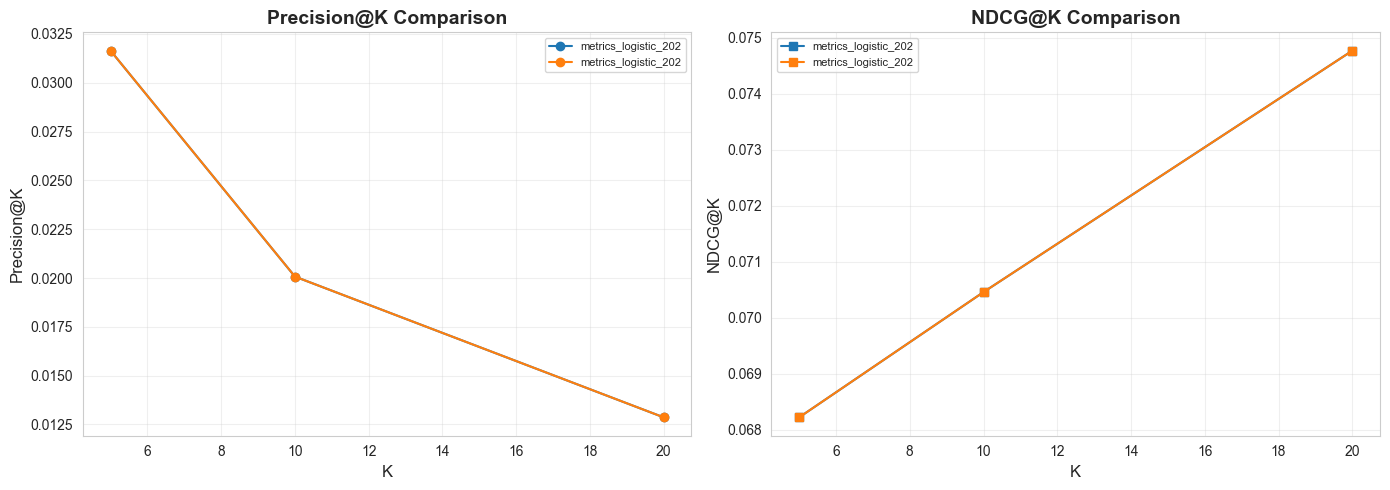

In [4]:
if len(all_metrics) > 0:
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Precision plot
    ax = axes[0]
    for filename, metrics in all_metrics.items():
        k_values = [int(k) for k in metrics['precision'].keys()]
        precision_values = [metrics['precision'][str(k)] for k in k_values]
        ax.plot(k_values, precision_values, marker='o', label=filename[:20])
    
    ax.set_xlabel('K', fontsize=12)
    ax.set_ylabel('Precision@K', fontsize=12)
    ax.set_title('Precision@K Comparison', fontsize=14, fontweight='bold')
    ax.legend(fontsize=8)
    ax.grid(True, alpha=0.3)
    
    # NDCG plot
    ax = axes[1]
    for filename, metrics in all_metrics.items():
        if 'ndcg' in metrics:
            k_values = [int(k) for k in metrics['ndcg'].keys()]
            ndcg_values = [metrics['ndcg'][str(k)] for k in k_values]
            ax.plot(k_values, ndcg_values, marker='s', label=filename[:20])
    
    ax.set_xlabel('K', fontsize=12)
    ax.set_ylabel('NDCG@K', fontsize=12)
    ax.set_title('NDCG@K Comparison', fontsize=14, fontweight='bold')
    ax.legend(fontsize=8)
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

## 4. Load and Analyze Predictions

In [5]:
if prediction_files:
    # Load latest predictions
    predictions = pl.read_parquet(prediction_files[-1])
    
    print("="*60)
    print("PREDICTIONS OVERVIEW")
    print("="*60)
    print(f"\nTotal predictions: {predictions.shape[0]:,}")
    print(f"Number of customers: {predictions['customer_id'].n_unique():,}")
    print(f"Number of unique items recommended: {predictions['item_id'].n_unique():,}")
    print(f"\nScore statistics:")
    print(predictions['score'].describe())

PREDICTIONS OVERVIEW

Total predictions: 8,214,459
Number of customers: 433,625
Number of unique items recommended: 8,474

Score statistics:
shape: (9, 2)
┌────────────┬────────────┐
│ statistic  ┆ value      │
│ ---        ┆ ---        │
│ str        ┆ f64        │
╞════════════╪════════════╡
│ count      ┆ 8.214459e6 │
│ null_count ┆ 0.0        │
│ mean       ┆ 0.01422    │
│ std        ┆ 0.094542   │
│ min        ┆ 0.0002     │
│ 25%        ┆ 0.001491   │
│ 50%        ┆ 0.002408   │
│ 75%        ┆ 0.00536    │
│ max        ┆ 0.997214   │
└────────────┴────────────┘


## 5. Top Recommended Items

In [6]:
if prediction_files:
    # Top items by recommendation frequency
    top_items = (
        predictions
        .group_by('item_id')
        .agg([
            pl.count().alias('num_recommendations'),
            pl.col('score').mean().alias('avg_score'),
            pl.col('rank').mean().alias('avg_rank')
        ])
        .sort('num_recommendations', descending=True)
        .head(20)
    )
    
    print("\nTop 20 Most Recommended Items:")
    print(top_items)

C:\Users\ASUS\AppData\Local\Temp\ipykernel_20900\3498965774.py:7: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
(Deprecated in version 0.20.5)
  pl.count().alias('num_recommendations'),



Top 20 Most Recommended Items:
shape: (20, 4)
┌───────────────┬─────────────────────┬───────────┬───────────┐
│ item_id       ┆ num_recommendations ┆ avg_score ┆ avg_rank  │
│ ---           ┆ ---                 ┆ ---       ┆ ---       │
│ str           ┆ u32                 ┆ f64       ┆ f64       │
╞═══════════════╪═════════════════════╪═══════════╪═══════════╡
│ 0007090000157 ┆ 393833              ┆ 0.010604  ┆ 2.936135  │
│ 0020010000210 ┆ 337499              ┆ 0.009114  ┆ 4.763739  │
│ 0020010000438 ┆ 332821              ┆ 0.008027  ┆ 5.788682  │
│ 0020010000440 ┆ 329930              ┆ 0.007725  ┆ 6.680914  │
│ 0020020000185 ┆ 323078              ┆ 0.007596  ┆ 7.705279  │
│ …             ┆ …                   ┆ …         ┆ …         │
│ 1774000000004 ┆ 150954              ┆ 0.004568  ┆ 16.976966 │
│ 2005000000004 ┆ 136342              ┆ 0.004054  ┆ 17.692054 │
│ 2005000000006 ┆ 126961              ┆ 0.004123  ┆ 18.51797  │
│ 2024000000010 ┆ 102933              ┆ 0.004032  ┆ 19.23

## 6. Recommendation Distribution

C:\Users\ASUS\AppData\Local\Temp\ipykernel_20900\2910109701.py:14: DeprecationWarning: `GroupBy.count` was renamed; use `GroupBy.len` instead
  rank_counts = predictions.group_by('rank').count().sort('rank')
C:\Users\ASUS\AppData\Local\Temp\ipykernel_20900\2910109701.py:24: DeprecationWarning: `GroupBy.count` was renamed; use `GroupBy.len` instead
  items_per_customer = predictions.group_by('customer_id').count()
C:\Users\ASUS\AppData\Local\Temp\ipykernel_20900\2910109701.py:33: DeprecationWarning: `GroupBy.count` was renamed; use `GroupBy.len` instead
  item_popularity = predictions.group_by('item_id').count().sort('count', descending=True)


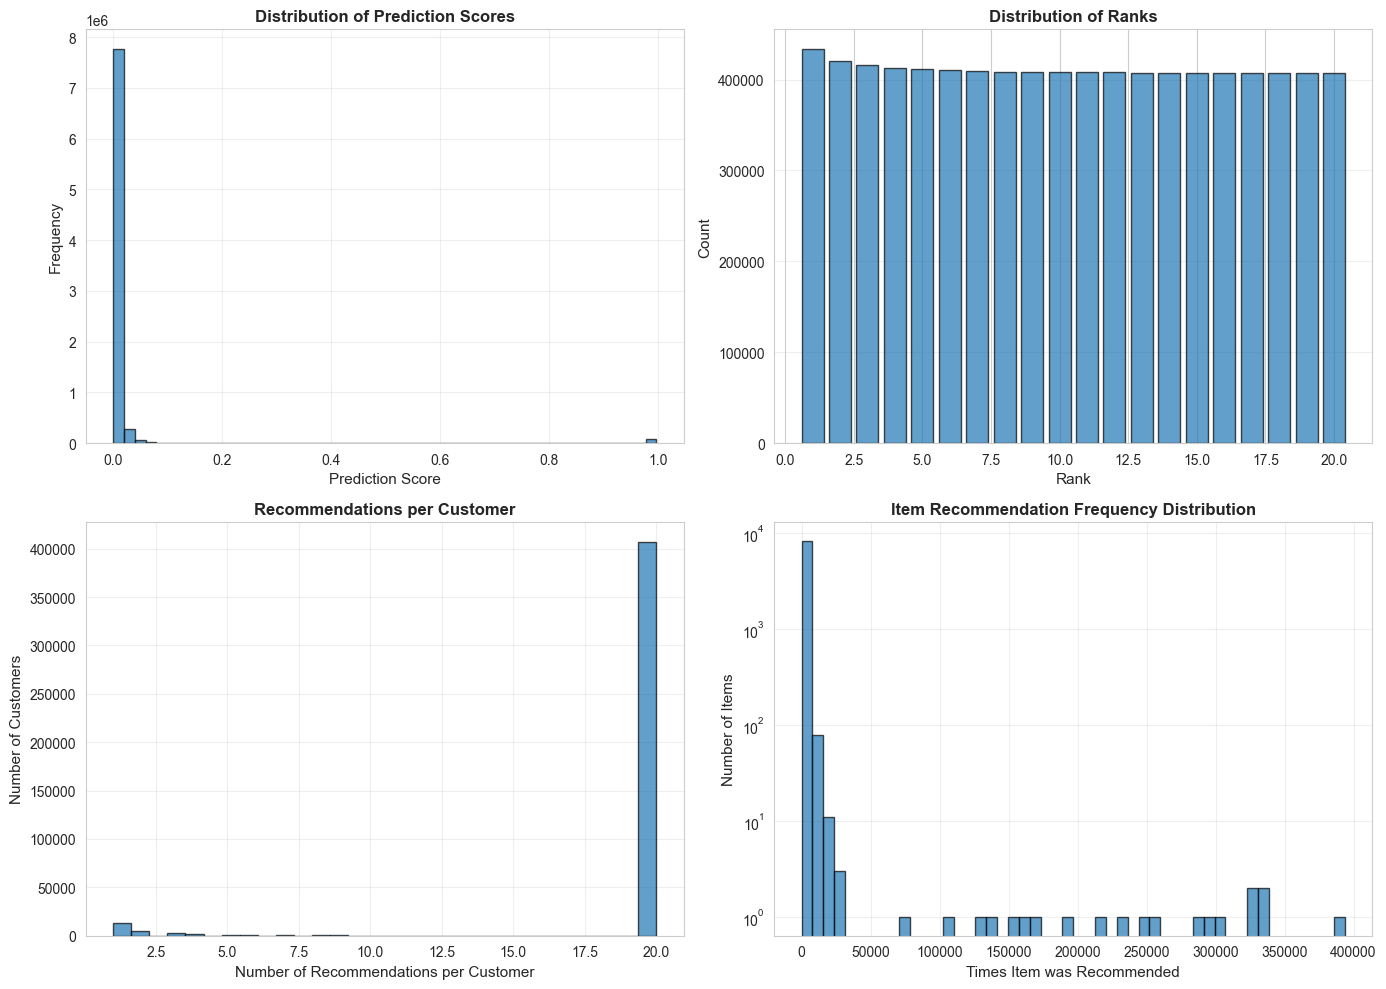

In [7]:
if prediction_files:
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    # Score distribution
    ax = axes[0, 0]
    ax.hist(predictions['score'].to_numpy(), bins=50, edgecolor='black', alpha=0.7)
    ax.set_xlabel('Prediction Score', fontsize=11)
    ax.set_ylabel('Frequency', fontsize=11)
    ax.set_title('Distribution of Prediction Scores', fontsize=12, fontweight='bold')
    ax.grid(True, alpha=0.3)
    
    # Rank distribution
    ax = axes[0, 1]
    rank_counts = predictions.group_by('rank').count().sort('rank')
    ax.bar(rank_counts['rank'].to_numpy(), rank_counts['count'].to_numpy(), 
           edgecolor='black', alpha=0.7)
    ax.set_xlabel('Rank', fontsize=11)
    ax.set_ylabel('Count', fontsize=11)
    ax.set_title('Distribution of Ranks', fontsize=12, fontweight='bold')
    ax.grid(True, alpha=0.3, axis='y')
    
    # Items per customer
    ax = axes[1, 0]
    items_per_customer = predictions.group_by('customer_id').count()
    ax.hist(items_per_customer['count'].to_numpy(), bins=30, edgecolor='black', alpha=0.7)
    ax.set_xlabel('Number of Recommendations per Customer', fontsize=11)
    ax.set_ylabel('Number of Customers', fontsize=11)
    ax.set_title('Recommendations per Customer', fontsize=12, fontweight='bold')
    ax.grid(True, alpha=0.3)
    
    # Item popularity (how many times each item was recommended)
    ax = axes[1, 1]
    item_popularity = predictions.group_by('item_id').count().sort('count', descending=True)
    ax.hist(item_popularity['count'].to_numpy(), bins=50, edgecolor='black', alpha=0.7)
    ax.set_xlabel('Times Item was Recommended', fontsize=11)
    ax.set_ylabel('Number of Items', fontsize=11)
    ax.set_title('Item Recommendation Frequency Distribution', fontsize=12, fontweight='bold')
    ax.grid(True, alpha=0.3)
    ax.set_yscale('log')
    
    plt.tight_layout()
    plt.show()

## 7. Sample Recommendations for Individual Customers

In [8]:
if prediction_files:
    # Show recommendations for 3 random customers
    sample_customers = predictions['customer_id'].unique().sample(3, seed=42).to_list()
    
    for customer_id in sample_customers:
        customer_recs = predictions.filter(pl.col('customer_id') == customer_id).sort('rank')
        print(f"\n{'='*60}")
        print(f"Recommendations for Customer: {customer_id}")
        print(f"{'='*60}")
        print(customer_recs.head(10))


Recommendations for Customer: 7589935
shape: (10, 4)
┌─────────────┬───────────────┬──────────┬──────┐
│ customer_id ┆ item_id       ┆ score    ┆ rank │
│ ---         ┆ ---           ┆ ---      ┆ ---  │
│ i32         ┆ str           ┆ f64      ┆ u32  │
╞═════════════╪═══════════════╪══════════╪══════╡
│ 7589935     ┆ 0007090000157 ┆ 0.001907 ┆ 1    │
│ 7589935     ┆ 0020010000210 ┆ 0.001907 ┆ 2    │
│ 7589935     ┆ 0020010000438 ┆ 0.001907 ┆ 3    │
│ 7589935     ┆ 0020010000440 ┆ 0.001907 ┆ 4    │
│ 7589935     ┆ 0020020000185 ┆ 0.001907 ┆ 5    │
│ 7589935     ┆ 0029120000029 ┆ 0.001907 ┆ 6    │
│ 7589935     ┆ 0029130000029 ┆ 0.001907 ┆ 7    │
│ 7589935     ┆ 0029130000030 ┆ 0.001907 ┆ 8    │
│ 7589935     ┆ 0175000000007 ┆ 0.001907 ┆ 9    │
│ 7589935     ┆ 0203000000004 ┆ 0.001907 ┆ 10   │
└─────────────┴───────────────┴──────────┴──────┘

Recommendations for Customer: 4589713
shape: (10, 4)
┌─────────────┬───────────────┬──────────┬──────┐
│ customer_id ┆ item_id       ┆ score    ┆

## 8. Feature Importance (if LogisticRegression)

Loading model from ../outputs/models\model_logistic_20251218_004923.pkl

FEATURE IMPORTANCE
shape: (13, 2)
┌──────────────────────────────┬───────────────┐
│ feature                      ┆ importance    │
│ ---                          ┆ ---           │
│ str                          ┆ f64           │
╞══════════════════════════════╪═══════════════╡
│ X5_purchase_frequency        ┆ 6.5485e6      │
│ X3_category_cnt_hist         ┆ 2.7402e6      │
│ X4_days_since_last_purchase  ┆ 2.5493e6      │
│ X1_brand_cnt_hist            ┆ 1.3612e6      │
│ X9_brand_diversity           ┆ 1.2755e6      │
│ …                            ┆ …             │
│ X7_avg_items_per_purchase    ┆ 129866.773376 │
│ X13_avg_item_popularity      ┆ 100577.235844 │
│ X10_category_diversity_score ┆ 84031.955479  │
│ X12_is_new_customer          ┆ 37389.470284  │
│ X11_purchase_day_mode        ┆ 1424.065186   │
└──────────────────────────────┴───────────────┘


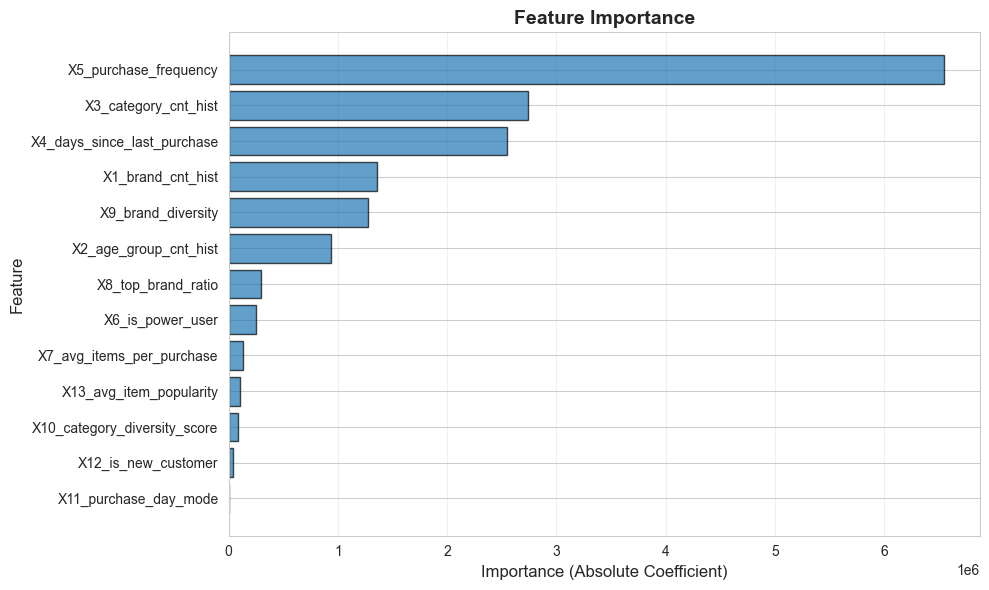

In [9]:
if model_files:
    from src.recommender import load_model, get_feature_importance
    
    # Load latest model
    model = load_model(model_files[-1])
    
    # Feature names
    feature_names = [
        'X1_brand_cnt_hist', 'X2_age_group_cnt_hist', 'X3_category_cnt_hist',
        'X4_days_since_last_purchase', 'X5_purchase_frequency', 'X6_is_power_user',
        'X7_avg_items_per_purchase', 'X8_top_brand_ratio', 'X9_brand_diversity',
        'X10_category_diversity_score', 'X11_purchase_day_mode', 'X12_is_new_customer',
        'X13_avg_item_popularity'
    ]
    
    try:
        importance = get_feature_importance(model, feature_names)
        
        print("\n" + "="*60)
        print("FEATURE IMPORTANCE")
        print("="*60)
        print(importance)
        
        # Plot
        plt.figure(figsize=(10, 6))
        plt.barh(importance['feature'].to_list()[::-1], 
                 importance['importance'].to_list()[::-1],
                 edgecolor='black', alpha=0.7)
        plt.xlabel('Importance (Absolute Coefficient)', fontsize=12)
        plt.ylabel('Feature', fontsize=12)
        plt.title('Feature Importance', fontsize=14, fontweight='bold')
        plt.grid(True, alpha=0.3, axis='x')
        plt.tight_layout()
        plt.show()
        
    except Exception as e:
        print(f"Could not compute feature importance: {e}")

## 9. Summary Report

In [10]:
print("="*70)
print("SUMMARY REPORT")
print("="*70)

print(f"\nModels trained: {len(model_files)}")
print(f"\nLatest Model Performance:")
if metrics_files:
    with open(metrics_files[-1]) as f:
        metrics = json.load(f)
    print(f"  - Precision@10: {metrics['precision']['10']:.4f}")
    print(f"  - NDCG@10: {metrics['ndcg']['10']:.4f}")

if prediction_files:
    print(f"\nPredictions:")
    print(f"  - Total recommendations: {predictions.shape[0]:,}")
    print(f"  - Customers covered: {predictions['customer_id'].n_unique():,}")
    print(f"  - Unique items recommended: {predictions['item_id'].n_unique():,}")

print("\n" + "="*70)

SUMMARY REPORT

Models trained: 2

Latest Model Performance:
  - Precision@10: 0.0201
  - NDCG@10: 0.0705

Predictions:
  - Total recommendations: 8,214,459
  - Customers covered: 433,625
  - Unique items recommended: 8,474

